In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

# Entrenamiento Solo Segmentación Semantica 

En este Notebook solo se realiza el entrenamiento de un modelo para predecir la segmentación debido a que primero se decidio abordar el problema resolviendo este problema, ya que se tenian 3000 imagenes con su respectica segmentación, y 2000 con la segmentación y el otro label

In [88]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Entendimiento de los datos 

Se crea un Dataset con el csv para entender el modo en que vienen los datos

In [3]:
dataset_directory ="train/" ## Cambie el directorio a donde se encuentren sus imagenes de Train
df1 = pd.read_csv(dataset_directory+"data.csv")

df1.head(2)

,timestamp,kiwibot_id,gps_point,lon,lat,roll,pitch,yaw,linear_speed,angular_speed,image_path,depth_path,image_lvl_label,label_path
0,2022-01-20 01:00:53.551000+00:00,4A009,POINT(-118.416716 33.972067),-118.416716,33.972067,-0.032725,-0.104720,-0.848666,0.161365,0.000000,6594-camera_color_image_raw-1642640453551.jpg,6594-camera_aligned_depth_to_color_image_raw-1...,2.0,6594-camera_color_image_raw-1642640453551_seg.png
1,2022-01-20 01:01:30.184000+00:00,4A009,POINT(-118.416908 33.972258),-118.416908,33.972258,0.063268,-0.076358,-2.261292,1.054795,0.092541,9c99-camera_color_image_raw-1642640490184.jpg,9c99-camera_aligned_depth_to_color_image_raw-1...,2.0,9c99-camera_color_image_raw-1642640490184_seg.png


Se re-ordena el dataset de forma diferente 

In [4]:
df1 = shuffle(df1).reset_index(drop=True)
df1 = shuffle(df1).reset_index(drop=True)
df1.head(2)

,timestamp,kiwibot_id,gps_point,lon,lat,roll,pitch,yaw,linear_speed,angular_speed,image_path,depth_path,image_lvl_label,label_path
0,2022-01-20 02:00:46.089000+00:00,4A009,POINT(-118.418493 33.969074),-118.418493,33.969074,0.001091,0.001091,0.001091,1.068296,-1.053801,3d8f-camera_color_image_raw-1642644046090.jpg,3d8f-camera_aligned_depth_to_color_image_raw-1...,2.0,3d8f-camera_color_image_raw-1642644046090_seg.png
1,2022-01-20 02:29:38.009000+00:00,4A009,POINT(-118.418154 33.970418),-118.418154,33.970418,0.001091,0.001091,0.001091,1.041574,1.280000,9301-camera_color_image_raw-1642645778010.jpg,9301-camera_aligned_depth_to_color_image_raw-1...,2.0,9301-camera_color_image_raw-1642645778010_seg.png


## Dataset de entrada 

Se crea una lista con las rutas donde se encuentran las imagenes

In [5]:
filenames  =list(df1['image_path'].map(lambda  x:dataset_directory+x))
labels= list(df1['label_path'].map(lambda  x:dataset_directory+x))

train_filenames = filenames[:2000]
test_filenames = filenames[:-100]

train_labels = labels[:2000]
test_labels  = labels[:-100]

Se crea un Dataser de Tensorflow

In [8]:
dataset_train =tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
dataset_test  =tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))

Se definen la función para leer las rutas y guardar las imagenes en el dataset

In [9]:
def _parse_function(filename, label):
    image_string = tf.io.read_file (filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    label_string = tf.io.read_file(label)
    label = tf.image.decode_png(label_string, channels=1)
    return image, label

dataset_train = dataset_train.map(_parse_function)
dataset_test = dataset_test.map(_parse_function)

In [10]:
dataset_train

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>

Se crea una función para cambiar el tamaño de las imagenes a uno estandar 

In [11]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_image = tf.image.resize(input_image, (128, 128))
  
  input_mask = tf.image.resize(input_mask, (128, 128))
  
  return input_image, input_mask

## Definición del modelo

Se definen algunos parametros

In [13]:
TRAIN_LENGTH = 1500
BATCH_SIZE = 64
BUFFER_SIZE = 2000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [17]:
train_images = dataset_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_images  =  dataset_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [18]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [19]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    img=tf.keras.utils.array_to_img(display_list[i])
    plt.imshow(img)
    plt.axis('off')
  plt.show()

Se muestran imagenes con su respectivo label de segmentación

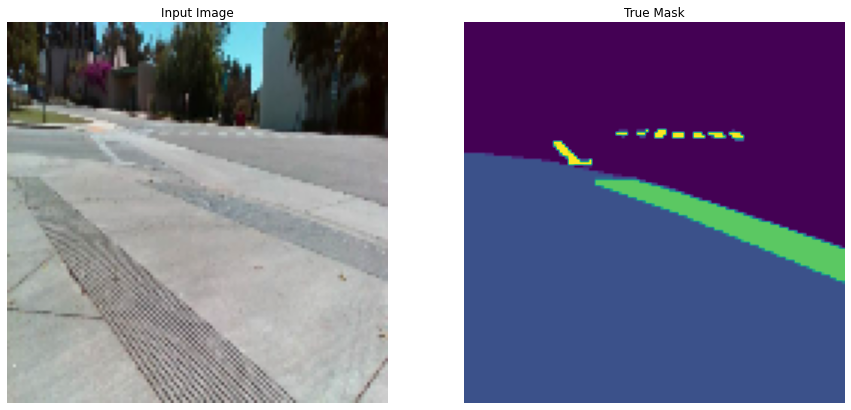

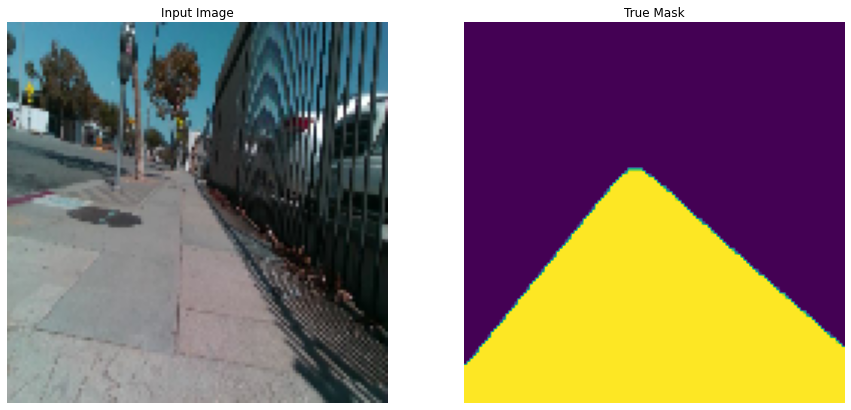

In [20]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Modelo

Se define un modelo con una red pre entranada y algunas capas mas

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Función MeanIoU

Se define una implementación de esta metrica para identificar como se comporta la red

In [ ]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def _init_(self, num_classes):

        super()._init_(num_classes= num_classes)

        self.num_classes = num_classes
    def update_state(self, y_true, y_pred, sample_weight=None):
        
        pred_mask = tf.argmax(y_pred, axis=-1)

        return super().update_state(y_true,pred_mask)

## Compilación del modelo

In [40]:
OUTPUT_CLASSES = 6

model = unet_model(output_channels=OUTPUT_CLASSES)


In [77]:
pt = tf.keras.optimizers.Adam(learning_rate=0.000000001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[MeanIoU(6)])

In [74]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [78]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Entrenamiento de la red

In [70]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [71]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 40ms/step


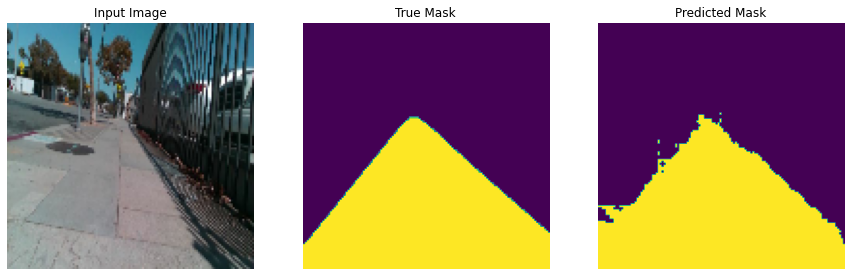


Sample Prediction after epoch 2

23/23 [==============================] - 52s 2s/step - loss: 0.0489 - mean_io_u_12: 0.8890


In [79]:
EPOCHS = 2
VAL_SUBSPLITS = 6
VALIDATION_STEPS = 100//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

            

Al final del entrenamiento se guarda el modelo en esa ubicación para luego ser usado en otro modelo que predecira los dos labels pedidos

In [80]:
model.save('saved_model/my_model_mean_iou_90')

INFO:tensorflow:Assets written to: saved_model/my_model_mean_iou_90\assets


INFO:tensorflow:Assets written to: saved_model/my_model_mean_iou_90\assets


## Modelos entrenados pruebas


A continuación se carga el modelo con mejores resuktados entrenado y se muestran sus resultados

In [85]:
model_2 = tf.keras.models.load_model('saved_model/my_model_mean_iou_94')

In [86]:
def show_predictions_prueba(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_2.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_2.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 3s 1s/step


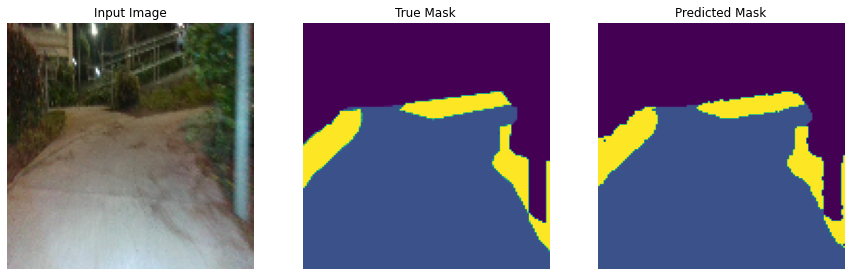

2/2 [==============================] - 3s 2s/step


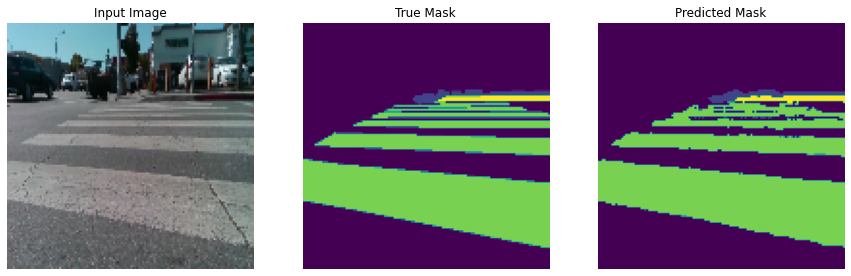

2/2 [==============================] - 2s 980ms/step


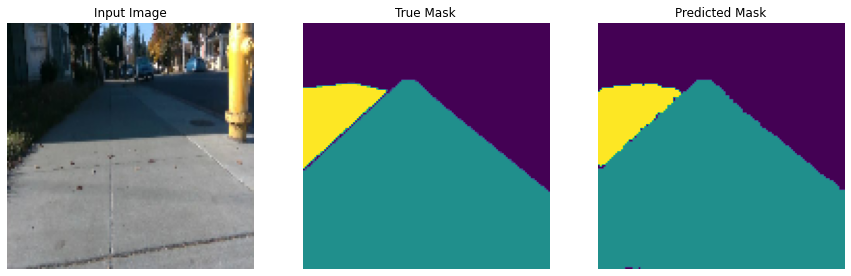

2/2 [==============================] - 2s 1s/step


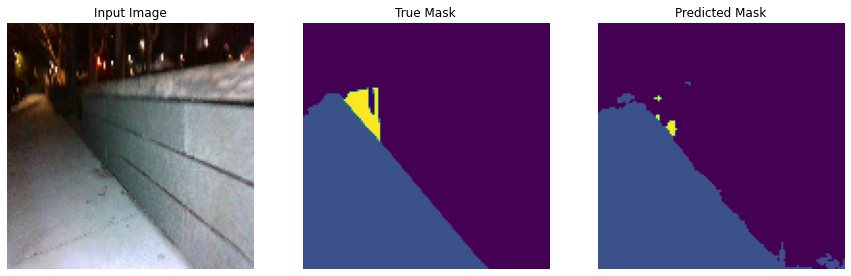

2/2 [==============================] - 3s 1s/step


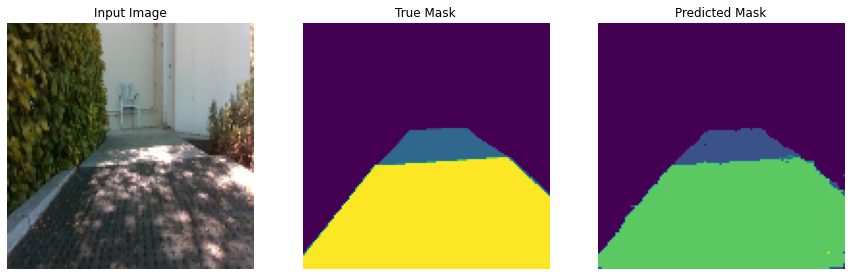

2/2 [==============================] - 3s 1s/step


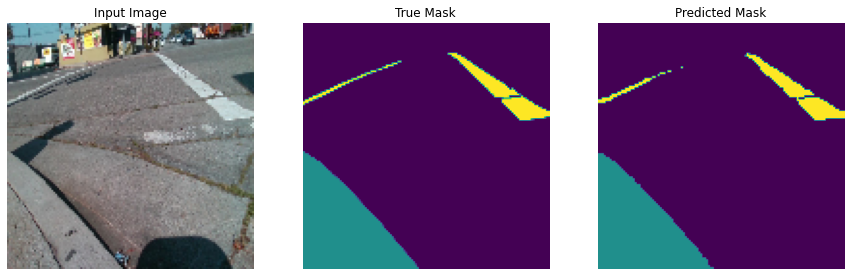

2/2 [==============================] - 3s 1s/step


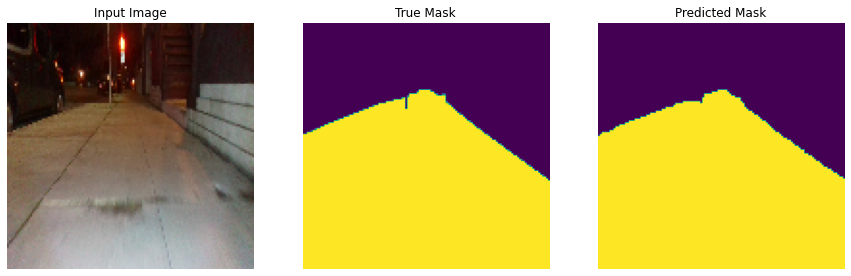

2/2 [==============================] - 3s 1s/step


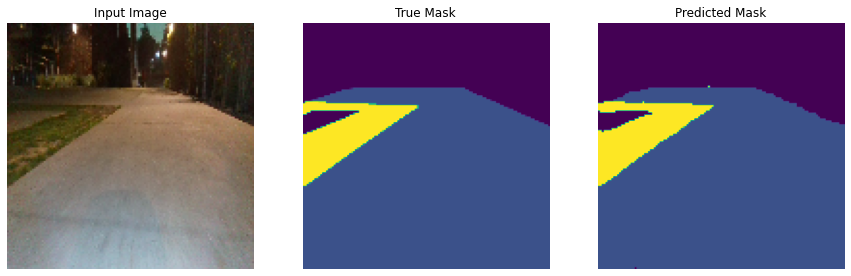

2/2 [==============================] - 3s 957ms/step


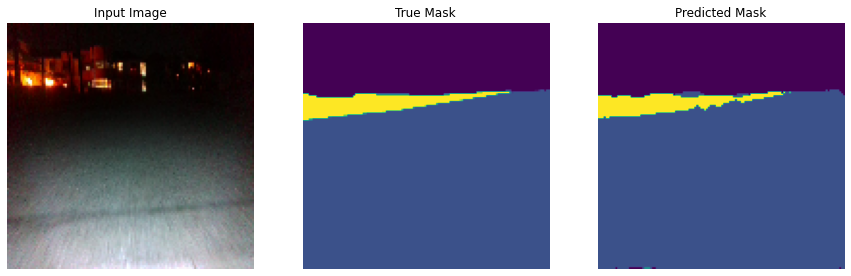

2/2 [==============================] - 3s 1s/step


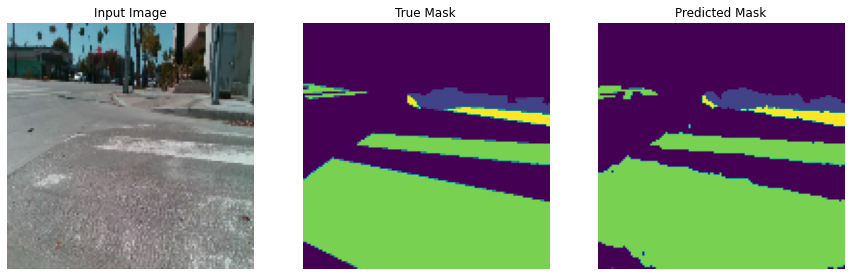

In [89]:
show_predictions_prueba(test_batches, 10)